# **Detecting Pneumonia from Chest X-rays using Convolutional Neural Networks**

## **Downloading data from Kaggle**

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "sushrutgaikwad"
os.environ['KAGGLE_KEY'] = "7d35f99822daf68b0a5cc2bc4756f94e"
! kaggle datasets download tolgadincer/labeled-chest-xray-images

 99% 1.16G/1.17G [00:09<00:00, 130MB/s]
100% 1.17G/1.17G [00:09<00:00, 129MB/s]


In [ ]:
! unzip labeled-chest-xray-images.zip

## **Importing Relevant Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from sklearn.metrics import confusion_matrix

## **Data Pre-processing**

### **Pre-processing the Training set**
Here, we create an instance of the `ImageDataGenerator` class. This helps us with image augmentation. Image augmentation is essential for making sure that our model doesn't overfit to the training set. We specify various parameters for image augmentation, e.g., `shear_range`, `zoom_range`, etc., which are self explanatory. These parameters do to some extent depend on the dataset we are working with. Parameters like `horizontal_flip` or `vertical_flip` may not be allowed in some datasets, e.g., handwritten digits, etc.

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        color_mode='grayscale',
        directory='/content/chest_xray/train',
        target_size=(500, 500),
        batch_size=32,
        class_mode='binary')

Found 5232 images belonging to 2 classes.


### **Pre-processing the Test set**
We do not add image augmentation to the test set except `rescale` since we want to evaluate our model based on it.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        color_mode='grayscale',
        directory='/content/chest_xray/test',
        target_size=(500, 500),
        batch_size=32,
        class_mode='binary')

Found 624 images belonging to 2 classes.


## **Building the CNN**

### **Initializing the CNN**
We will initialize the CNN as a sequence of layers. This is done using the `Sequential` class in the following way.

In [ ]:
cnn = tf.keras.models.Sequential()

### **Adding a sequence of Convolutional and Pooling layers**
After initializing the CNN as a sequence of layers, we sequentially add convolutional and pooling layers in the following way.

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',
                               input_shape=[500, 500, 1]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

I have progressively doubled the number of filters from the first layers to the last layer in the above sequence. This is a standard way of building a CNN.

### **Flattening the layer and adding dropout regularization**
We flatten the output of the above layers using `Flatten`. We add dropout regularization to avoid overfitting.

In [ ]:
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dropout(0.2))

### **Adding two fully connected layers and dropout regularization**
Fully connected layers are added using the `Dense` class in the following way.

In [ ]:
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

### **Adding the final output layer**
Since this is a binary classification problem (either pneumonia is detected or not), there will just be a single final output unit, and the activation function would be sigmoid.

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## **Training the Model**

### **Compiling the CNN**
Here, we define the loss function, the optimizer, and the metric we want to track while training the model.

In [ ]:
cnn.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

### **Callbacks**
Callbacks can be used for various tasks. I will be using it for early stopping while monitoring the validation loss. We define callbacks in the following way. Further, we will add these callbacks while fitting our model.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
callbacks_list = [early_stop]

### **Model Summary**
Let's have a look at the model summary. It gives us information about each and every layer of our model, and the number of parameters (trainable and non-trainable).

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        3

We can see that our model has $\approx1$ million trainable parameters, and no non-trainable parameters.

### **Training the CNN on the Training set and evaluating it on the Test set**

In [ ]:
r = cnn.fit(x = training_set,
        validation_data = test_set,
        epochs = 25,
        callback = callbacks_list)

Epoch 1/25
164/164 [==============================] - 207s 1s/step - loss: 0.4167 - accuracy: 0.8121 - val_loss: 0.2766 - val_accuracy: 0.8894
Epoch 2/25
164/164 [==============================] - 170s 1s/step - loss: 0.2513 - accuracy: 0.9060 - val_loss: 0.6327 - val_accuracy: 0.7644
Epoch 3/25
164/164 [==============================] - 171s 1s/step - loss: 0.2086 - accuracy: 0.9230 - val_loss: 0.2687 - val_accuracy: 0.8782
Epoch 4/25
164/164 [==============================] - 170s 1s/step - loss: 0.1992 - accuracy: 0.9239 - val_loss: 0.2410 - val_accuracy: 0.9119
Epoch 5/25
164/164 [==============================] - 170s 1s/step - loss: 0.1932 - accuracy: 0.9218 - val_loss: 0.2776 - val_accuracy: 0.8798
Epoch 6/25
164/164 [==============================] - 171s 1s/step - loss: 0.1715 - accuracy: 0.9329 - val_loss: 0.3155 - val_accuracy: 0.8766
Epoch 7/25
164/164 [==============================] - 171s 1s/step - loss: 0.1683 - accuracy: 0.9343 - val_loss: 0.2895 - val_accuracy: 0.8942

## **Plotting the loss and accuracy**

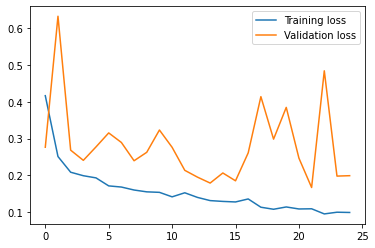

In [ ]:
# Losses
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend();

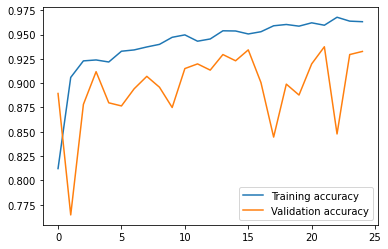

In [ ]:
# Accuracies
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend();